In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch.autograd import Variable

In [2]:
def generate_data(n_samples_1, n_samples_2, noise_level, seed=15, display=False):
    n_samples_1, n_samples_3 = int(n_samples_1 / 2), int(n_samples_1 / 2)
    n_samples_2, n_samples_4 = int(n_samples_2 / 2), int(n_samples_2 / 2)
    centers = [[0.0, 0.0], [0.0, 1.5], [1.5, 1.5], [1.5, 0.0]]
    clusters_std = [0.5, 0.5, 0.5, 0.5]
    X, y = make_blobs(n_samples=[n_samples_1, n_samples_2, n_samples_3, n_samples_4],
                      centers=centers,
                      cluster_std=clusters_std,
                      random_state = 15,
                      shuffle=False)
    
    # Set diagnoals to be the same class
    y = y % 2
    
    # Split into train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # Create 1:9 majority:minority class imbalance for training data
    class_0_idxs = np.where(y_train == 0)[0] # Majority class
    class_1_idxs = np.where(y_train == 1)[0] # Minority class
    new_class_0_size = len(class_1_idxs) // 9
    new_class_0_idxs = np.random.choice(class_0_idxs, new_class_0_size)
    new_idxs = list(new_class_0_idxs) + list(class_1_idxs)
    X_train = X_train[new_idxs]
    y_train = y_train[new_idxs]
    
    # Randomly flip a percentage of training labels
    n = len(y_train)
    y_train = np.array([abs(1 - y_train[i]) if i in random.sample(range(n), int(noise_level * n)) else y_train[i] for i in range(n)])

    if display:
        plt.scatter(X_train[:,0], X_train[:,1], c=['#516091' if y==1 else '#A9ECA2' for y in y_train])
#         plt.savefig('class_imbalance_train_5_percent_noise.png')
    y_train = y_train.reshape(-1, 1)
    X_train = torch.tensor(X_train, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.float)
    
    y_test = y_test.reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.float)
    
    return X_train, X_test, y_train, y_test

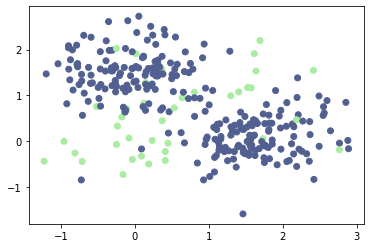

In [3]:
X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, display=True)

In [4]:
import sys
sys.path.insert(0, '/Users/william/Documents/CMU/Research/RiskSensitiveLearning/SupervisedLearning/objectives')
import cvar, human_aligned_risk, entropic_risk, trimmed_risk, mean_variance

In [5]:
input_size = 2
hidden_size = 2
output_size = 2

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        return x
    
epochs = 5000
learning_rate = 1e-2

In [6]:
%load_ext autoreload
%autoreload 2

# Empirical Risk Minimization

In [112]:
seeds = [2, 3, 4, 5, 6, 7]
objectives = {
#     'Expected Value': nn.CrossEntropyLoss(),
    'CVaR': cvar.CVaR(a=0.1), # We look at bottom alpha% of losses
}

for objective in objectives.keys():
    losses = []
    cvars = []
    accs = []

    for seed in seeds:
        X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, seed=seed)
        # Get objective
        criterion = objectives[objective]

        # Reset random seeds for comparaison.
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        model = TwoLayerMLP(input_size, hidden_size, output_size)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

        # Train
        model.train()
        for epoch in range(epochs):
            # clear the gradients so they wont accumulate
            optimizer.zero_grad()

            output = model(X_train)
            loss = criterion(output, y_train.squeeze(1).type(torch.LongTensor))

            # calculate gradient
            loss.backward()

            # gradient descent
            optimizer.step()

        model.eval()

        loss_criterion = nn.CrossEntropyLoss()
        cvar_criterion = cvar.CVaR(a=0.01)

        correct = 0
        incorrect = 0
        with torch.no_grad():
            output = model(X_test)
            pred = torch.argmax(F.softmax(output, dim=1), dim=1)
            overall_acc = sum(1 for x, y in zip(pred, y_test) if x == y) / len(pred)
            accs.append(overall_acc)

            losses.append(loss_criterion(output, y_test.squeeze(1).type(torch.LongTensor)))
            cvars.append(cvar_criterion(output, y_test.squeeze(1).type(torch.LongTensor)))
    print('Objective: {}, Average Accuracy: {}, Average Loss: {}, Average CVaR: {}'.format(objective, np.mean(accs), np.mean(losses), np.mean(cvars)))


Objective: CVaR, Average Accuracy: 0.35462962962962963, Average Loss: 0.6961986422538757, Average CVaR: 0.7141345143318176


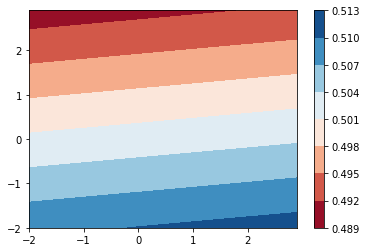

In [113]:
# define bounds of the domain
min1, max1 = -2, 3
min2, max2 = -2, 3

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# Joint DRO / Trunc-CVaR

In [114]:
seeds = [2, 3, 4, 5, 6, 7]

objectives = {
    'Joint DRO': nn.CrossEntropyLoss(reduction='none')
}

epochs = 5000

for objective in objectives.keys():
    losses = []
    cvars = []
    accs = []

    for seed in seeds:
        X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, seed=seed)
        # Get objective
        criterion = objectives[objective]

        # Reset random seeds for comparaison.
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        model = TwoLayerMLP(2, 2, 2)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

        eta = 0
        eta_lr = 1e-2
        eta = Variable(torch.zeros(1), requires_grad=True)
        alpha = 0.1

        # Train
        model.train()
        for epoch in range(epochs):
            # clear the gradients so they wont accumulate
            optimizer.zero_grad()

            output = model(X_train)

            loss_eta = criterion(output, y_train.squeeze(1).type(torch.LongTensor)) - eta
            loss = (1 / alpha) * torch.mean(torch.relu(loss_eta)) + eta

            # calculate gradient
            loss.backward(retain_graph=True)

            # gradient descent
            optimizer.step()
            
            # Update eta
            eta.data -= eta_lr * eta.grad.data

            # Clear variable gradients
            eta.grad.data.zero_()

        model.eval()

        loss_criterion = nn.CrossEntropyLoss()
        cvar_criterion = cvar.CVaR(a=0.01)

        correct = 0
        incorrect = 0
        with torch.no_grad():
            output = model(X_test)
            pred = torch.argmax(F.softmax(output, dim=1), dim=1)
            overall_acc = sum(1 for x, y in zip(pred, y_test) if x == y) / len(pred)
            accs.append(overall_acc)

            losses.append(loss_criterion(output, y_test.squeeze(1).type(torch.LongTensor)))
            cvars.append(cvar_criterion(output, y_test.squeeze(1).type(torch.LongTensor)))
    print('Objective: {}, Average Accuracy: {}, Average Loss: {}, Average CVaR: {}'.format(objective, np.mean(accs), np.mean(losses), np.mean(cvars)))



Objective: Joint DRO, Average Accuracy: 0.31597222222222227, Average Loss: 0.7026169896125793, Average CVaR: 0.7460222244262695


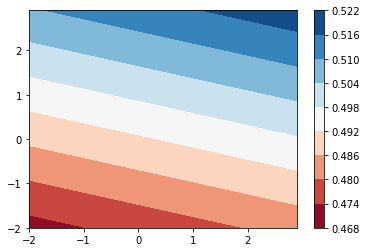

In [115]:
# define bounds of the domain
min1, max1 = -2, 3
min2, max2 = -2, 3

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# Adaptive Sampling

In [116]:
from adacvar.util.cvar import CVaR, SoftCVaR
from adacvar.util.adaptive_algorithm import Exp3Sampler
from torch.utils.data import Dataset, DataLoader
from adacvar.util.learning_rate_decay import AdaGrad, Constant, RobbinsMonro

In [118]:
def get_adaptive_algorithm(is_adaptive, dataset, alpha, bsz, eta, gamma=0, beta=0, eps=0):
    num_points = len(dataset)
    
    if is_adaptive:
        iid_batch = False
    else:
        eta = 1e-2
        gamma = 0
        beta = 0
        eps = 1e-16
        iid_batch = True
        
    exp3 = Exp3Sampler(
            batch_size=bsz,
            num_actions=num_points,
            size=int(np.ceil(alpha * num_points)),
            eta=eta,
            gamma=gamma,
            beta=beta,
            eps=eps,
            iid_batch=iid_batch,
        )
    loader = DataLoader(dataset, batch_sampler=exp3)
    return loader, loader.batch_sampler

In [8]:
alpha = 0.1
seeds = [2, 3, 4, 5, 6, 7]
epochs = 3000
objectives = {
#     'Adaptive Sampling': CVaR(alpha=1, learning_rate=0),
#     'Mean': CVaR(alpha=1, learning_rate=0),
#     'Trunc CVaR': CVaR(alpha=alpha, learning_rate=1e-3),
    'Soft CVaR': SoftCVaR(alpha=alpha, learning_rate=1e-3, temperature=1.0)
}

for objective in objectives.keys():
    losses = []
    cvars = []
    accs = []

    for seed in seeds:
        X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, seed=seed)
        # Get CVaR Objective
        cvar = objectives[objective]
        criterion = nn.CrossEntropyLoss(reduction='none')

        # Reset random seeds for comparaison.
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        model = TwoLayerMLP(2, 2, 2)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#         exp3_lr = np.sqrt(1 / alpha * np.log(1 / alpha))
        horizon = epochs
        exp3_lr = RobbinsMonro(0.5, len(X_train))
#         print(exp3_lr)
        is_adaptive = objective == 'Adaptive Sampling'
        train_dataset = NoisyLabelDataset(X_train, y_train)
        train_loader, adaptive_algorithm = get_adaptive_algorithm(is_adaptive, train_dataset, alpha, len(X_train), exp3_lr)

        # Train
        model.train()
        for epoch in range(epochs):
            for batch_idx, (data, target, idx) in enumerate(train_loader):
                # Sample data
                data, target = data.to('cpu'), target.to('cpu')

                # clear the gradients so they wont accumulate
                optimizer.zero_grad()
                cvar.zero_grad()

                output = model(data)

                loss = criterion(output, target.squeeze(1).type(torch.LongTensor))

                # batch sampler (not cyclic sampler line 93 adacvar.util.train.py)
                weights = 1.0
                probabilities = adaptive_algorithm.probabilities

                # Feedback loss to sampler.
                adaptive_algorithm.update(
                    1 - np.clip(loss.cpu().detach().numpy(), 0, 1), idx, probabilities
                )

                # Calculate CVaR and Reduce to mean.
                cvar_loss = (torch.tensor(weights).float().to('cpu') * cvar(loss)).mean()
                loss = loss.mean()

                # Compute Criterion and back-propagate.
                cvar_loss.backward()

                # gradient descent
                optimizer.step()
                cvar.step()

#                     print('Epoch: {}, Batch idx: {}, CVaR: {}, Loss: {}, VaR: {}'.format(epoch, batch_idx, cvar_loss, loss, cvar.var))

                # Renormalize sampler
                adaptive_algorithm.normalize()

        model.eval()

        loss_criterion = nn.CrossEntropyLoss()
#         cvar_criterion = cvar.CVaR(a=0.01)

        correct = 0
        incorrect = 0
        with torch.no_grad():
            output = model(X_test)
            pred = torch.argmax(F.softmax(output, dim=1), dim=1)
            overall_acc = sum(1 for x, y in zip(pred, y_test) if x == y) / len(pred)
            accs.append(overall_acc)

            losses.append(loss_criterion(output, y_test.squeeze(1).type(torch.LongTensor)))
            cvars.append(cvar_criterion(output, y_test.squeeze(1).type(torch.LongTensor)))
    print('Objective: {}, Average Accuracy: {}, Average Loss: {}, Average CVaR: {}'.format(objective, np.mean(accs), np.mean(losses), np.mean(cvars)))



NameError: name 'LogisticRegression' is not defined

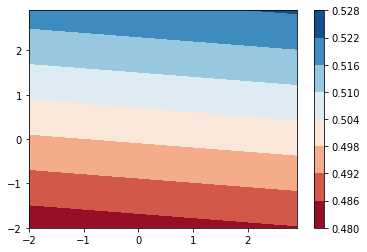

In [122]:
# define bounds of the domain
min1, max1 = -2, 3
min2, max2 = -2, 3

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# Learning Models with Uniform Performance via DRO

In [7]:
ks = [1.5] + [i for i in np.arange(2, 11, 2)]
rhos = [1.5] + [i for i in np.arange(2, 11, 2)]
seeds = [15, 30]
objectives = {
    'Uniform Performance': nn.CrossEntropyLoss(reduction='none')
}

results = dict()

for k in ks:
    for rho in rhos:
        print('TESTING: k: {}, rho: {}'.format(k, rho))
        
        k_star =  k / (k - 1)
        c_k = (1 + k * (k - 1) * rho) ** (1 / k)
        
        results_key = 'k=' + str(k) + '_rho=' + str(rho)
        results[results_key] = dict()
        
        for objective in objectives.keys():
            majority_accuracies = []
            minority_accuracies = []
            overall_accuracies = []

            for seed in seeds:
                X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, seed=seed)
                # Get objective
                criterion = objectives[objective]

                # Reset random seeds for comparaison.
                torch.manual_seed(seed)
                random.seed(seed)
                np.random.seed(seed)

                model = TwoLayerMLP(input_size, hidden_size, output_size)
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

                eta = 0
                eta_lr = 1e-2
                eta = Variable(torch.zeros(1), requires_grad=True)

                # Train
                model.train()
                for epoch in range(epochs):
                    # clear the gradients so they wont accumulate
                    optimizer.zero_grad()

                    output = model(X_train)

                    loss_eta = (criterion(output, y_train.squeeze(1).type(torch.LongTensor)) - eta) ** k_star
                    loss = c_k * torch.mean(torch.relu(loss_eta)) ** (1 / k_star) + eta

                    # calculate gradient
                    loss.backward(retain_graph=True)

                    # gradient descent
                    optimizer.step()
            
                    # Update eta
                    eta.data -= eta_lr * eta.grad.data

                    # Clear variable gradients
                    eta.grad.data.zero_()

                model.eval()
                correct = 0
                incorrect = 0
                with torch.no_grad():
                    output = model(X_test)
                    pred = torch.argmax(F.softmax(output, dim=1), dim=1)
                    overall_acc = sum(1 for x, y in zip(pred, y_test) if x == y) / len(pred)

                    majority_idxs = torch.where(y_test == 0)[0]
                    minority_idxs = torch.where(y_test == 1)[1]

                    majority_acc = sum(1 for x, y in zip(pred[majority_idxs], y_test[majority_idxs]) if x == y) / len(pred[majority_idxs])
                    minority_acc = sum(1 for x, y in zip(pred[minority_idxs], y_test[minority_idxs]) if x == y) / len(pred[minority_idxs])

                    majority_accuracies.append(majority_acc)
                    minority_accuracies.append(minority_acc)
                    overall_accuracies.append(overall_acc)
            results[results_key]['majority'] = np.mean(majority_accuracies)
            results[results_key]['minority'] = np.mean(minority_accuracies)
            results[results_key]['overall'] = np.mean(overall_accuracies)
            print('Objective: {}, Majority Accuracy: {}, Minority Accuracy: {}, Overall Accuracy: {}\n'.format(objective, np.mean(majority_accuracies), np.mean(minority_accuracies), np.mean(overall_accuracies)))
                
        print('\n')

TESTING: k: 1.5, rho: 1.5
Objective: Uniform Performance, Majority Accuracy: 0.3685543889959466, Minority Accuracy: 0.5, Overall Accuracy: 0.41041666666666665



TESTING: k: 1.5, rho: 2
Objective: Uniform Performance, Majority Accuracy: 0.05705528606551931, Minority Accuracy: 0.5, Overall Accuracy: 0.1840277777777778



TESTING: k: 1.5, rho: 4
Objective: Uniform Performance, Majority Accuracy: 0.2356496555695838, Minority Accuracy: 0.0, Overall Accuracy: 0.2916666666666667



TESTING: k: 1.5, rho: 6
Objective: Uniform Performance, Majority Accuracy: 0.5463153697920127, Minority Accuracy: 0.0, Overall Accuracy: 0.5194444444444444



TESTING: k: 1.5, rho: 8
Objective: Uniform Performance, Majority Accuracy: 0.10079850266905885, Minority Accuracy: 0.5, Overall Accuracy: 0.21250000000000002



TESTING: k: 1.5, rho: 10
Objective: Uniform Performance, Majority Accuracy: 0.32069960351739873, Minority Accuracy: 0.5, Overall Accuracy: 0.38680555555555557



TESTING: k: 2, rho: 1.5
Objective: Un

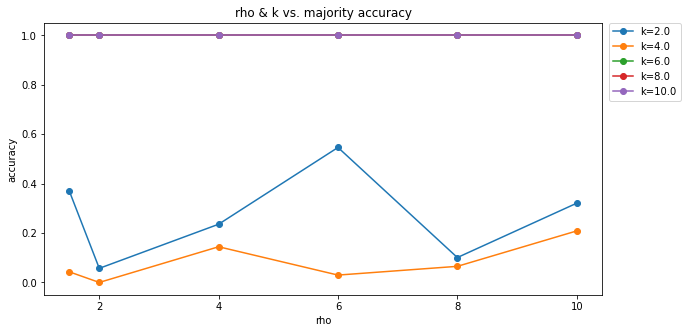

In [8]:
key = 'majority'
last_k = 1.5
rhos = []
accs = []
plt.figure(figsize=(10,5))
for results_key in results:
    items = results_key.split('=')
    k = float(items[1].split('_')[0])
    rho = float(items[-1])
    if k != last_k:
        last_k = k
        plt.plot(rhos, accs, marker='o', label='k=' + str(k))
        rhos = []
        accs = []
    rhos.append(rho)
    accs.append(results[results_key][key])
plt.legend(bbox_to_anchor=(1.15, 1.02))
plt.title('rho & k vs. ' + key + ' accuracy')
plt.xlabel('rho')
plt.ylabel('accuracy')
plt.show()

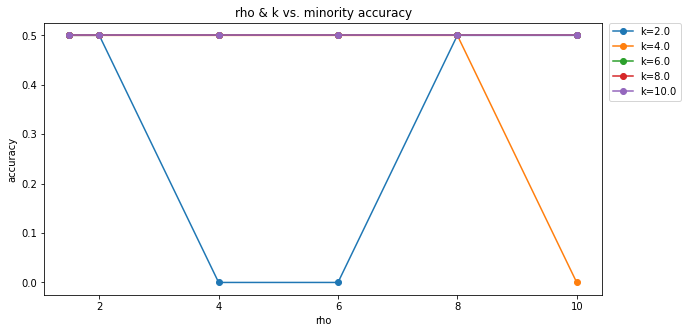

In [9]:
key = 'minority'
last_k = 1.5
rhos = []
accs = []
plt.figure(figsize=(10,5))
for results_key in results:
    items = results_key.split('=')
    k = float(items[1].split('_')[0])
    rho = float(items[-1])
    if k != last_k:
        last_k = k
        plt.plot(rhos, accs, marker='o', label='k=' + str(k))
        rhos = []
        accs = []
    rhos.append(rho)
    accs.append(results[results_key][key])
plt.legend(bbox_to_anchor=(1.15, 1.02))
plt.title('rho & k vs. ' + key + ' accuracy')
plt.xlabel('rho')
plt.ylabel('accuracy')
plt.show()

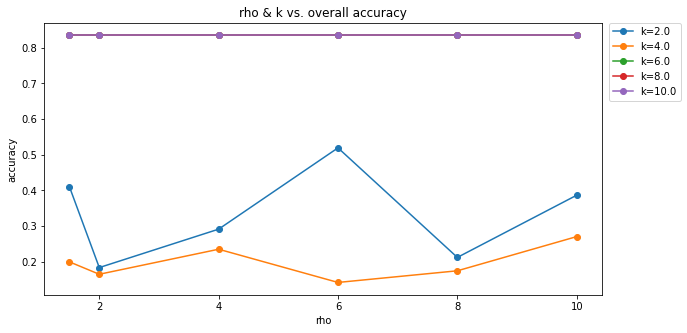

In [10]:
key = 'overall'
last_k = 1.5
rhos = []
accs = []
plt.figure(figsize=(10,5))
for results_key in results:
    items = results_key.split('=')
    k = float(items[1].split('_')[0])
    rho = float(items[-1])
    if k != last_k:
        last_k = k
        plt.plot(rhos, accs, marker='o', label='k=' + str(k))
        rhos = []
        accs = []
    rhos.append(rho)
    accs.append(results[results_key][key])
plt.legend(bbox_to_anchor=(1.15, 1.02))
plt.title('rho & k vs. ' + key + ' accuracy')
plt.xlabel('rho')
plt.ylabel('accuracy')
plt.show()

# Distributionally Robust Losses for Latent Covariate Mixtures

In [11]:
# Precompute because slow
c = torch.combinations(torch.arange(0, X_train.shape[0]), with_replacement=True)
combined = torch.cat((c, c.flip(1)), dim=0).unique(dim=0)
X_diff = torch.sub(X_train[combined][:,0,:], X_train[combined][:,1,:])
X_norms = torch.linalg.norm(X_diff**(p-1), dim=1)

/var/folders/3y/bpcn5gxx3cq65qn2wd45rnhm0000gn/T/ipykernel_6971/698506951.py:2: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  c = torch.combinations(torch.arange(0, X_train.shape[0]), with_replacement=True)


NameError: name 'p' is not defined

In [ ]:
p = 2 # Must be a whole number?
eps = 10
L = 1.5

seeds = [15]
objectives = {
    'DRO Mixture': nn.CrossEntropyLoss(reduction='none')
}
        
for objective in objectives.keys():
    majority_accuracies = []
    minority_accuracies = []
    overall_accuracies = []

    for seed in seeds:
        X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, seed=seed)
        # Get objective
        criterion = objectives[objective]

        # Reset random seeds for comparaison.
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        bsz = len(y_train) # Full batch GD

        model = TwoLayerMLP(input_size, hidden_size, output_size)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

        eta_lr = 1e-2
        Beta_lr = 1e-2
        eta = Variable(torch.zeros(1), requires_grad=True)
        Beta = Variable(torch.ones(bsz, bsz), requires_grad=True)
        rows = torch.arange(0, bsz)

        # Train
        model.train()
        for epoch in range(epochs):
            # clear the gradients so they wont accumulate
            optimizer.zero_grad()

            output = model(X_train)

            loss = criterion(output, y_train.squeeze(1).type(torch.LongTensor))

            diag_diff = Beta[rows] - torch.transpose(Beta, 0, 1)[rows]
            loss = ((p - 1) * torch.mean(torch.relu(loss - torch.mean(diag_diff, dim=1) - eta))**p)**(1 / p)
            loss += L**(p - 1) / (eps * bsz**2) * torch.sum(torch.mul(X_norms, Beta.flatten()))

            # calculate gradient
            loss.backward(retain_graph=True)

            # gradient descent
            optimizer.step()

            # Update eta
            eta.data -= eta_lr * eta.grad.data

            # Update Beta
            Beta.data -= Beta_lr * Beta.grad.data
            Beta.data = torch.relu(Beta.data)

            # Clear variable gradients
            eta.grad.data.zero_()
            Beta.grad.data.zero_()

        model.eval()
        correct = 0
        incorrect = 0
        with torch.no_grad():
            output = model(X_test)
            pred = torch.argmax(F.softmax(output, dim=1), dim=1)
            overall_acc = sum(1 for x, y in zip(pred, y_test) if x == y) / len(pred)

            majority_idxs = torch.where(y_test == 0)[0]
            minority_idxs = torch.where(y_test == 1)[1]

            majority_acc = sum(1 for x, y in zip(pred[majority_idxs], y_test[majority_idxs]) if x == y) / len(pred[majority_idxs])
            minority_acc = sum(1 for x, y in zip(pred[minority_idxs], y_test[minority_idxs]) if x == y) / len(pred[minority_idxs])

            majority_accuracies.append(majority_acc)
            minority_accuracies.append(minority_acc)
            overall_accuracies.append(overall_acc)
    print('Objective: {}, Majority Accuracy: {}, Minority Accuracy: {}, Overall Accuracy: {}\n'.format(objective, np.mean(majority_accuracies), np.mean(minority_accuracies), np.mean(overall_accuracies)))



## Verification of 2nd term vectorization

In [ ]:
X_train.shape

In [ ]:
c = torch.combinations(torch.arange(0, X_train.shape[0]), with_replacement=True)
c

In [ ]:
combined = torch.cat((c, c.flip(1)), dim=0).unique(dim=0)

In [ ]:
combined

In [ ]:
X_train[combined]

In [ ]:
diff = torch.sub(X_train[combined][:,0,:], X_train[combined][:,1,:])
diff

In [ ]:
Beta = torch.arange(0, len(X_train)*len(X_train))
Beta

In [ ]:
norms = torch.linalg.norm(diff**2, dim=1)
norms

In [ ]:
sum_terms = torch.mul(norms, Beta.flatten())
sum_terms

In [ ]:
torch.sum(norms)

## Verification of 1st term vectorization

In [ ]:
b = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b

In [ ]:
b[1] - b[:,1]

In [ ]:
r = torch.arange(0, b.shape[0])
r

In [ ]:
print(b[r][1])
print(torch.transpose(b, 0, 1)[r][1])

In [ ]:
diag_diff = b[r] - torch.transpose(b, 0, 1)[r]
diag_diff

In [ ]:
torch.mean(diag_diff, dim=1)